In [1]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image
import time
import json
from tqdm import tqdm
from torch.utils.data import random_split
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.models.resnet import ResNet50_Weights

In [2]:
# Params
training_date = time.strftime("%Y%m%d-%H%M%S")
BACTH_SIZE = 32
MODEL_NAME = f'MDM_IaA_{training_date}'
DATASET_FILE_PATH = 'C:/Users/janny/Aalto_project_2/data/elsaesserstr1_dataset_IaA.txt'
MODEL_DIR = os.path.join("C:/Users/janny/Aalto_project_2/models", MODEL_NAME)

In [3]:
os.makedirs(MODEL_DIR, exist_ok=True)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [5]:
class CustomDataset(Dataset):
    def __init__(self, annotations_file, transform=None, target_transform=None):
        self.annotations = pd.read_csv(annotations_file, sep=', ', header=None)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        row = self.annotations.iloc[idx]
        img_paths = row[:5].values  # Paths to the image files
        spectrogram_paths = row[5:12].values  # Paths to the audio spectrogram files
        label = row[12]
        
        # Load images and spectrograms, apply the same transform if available
        images = [read_image(path) for path in img_paths]
        spectrograms = [read_image(path) for path in spectrogram_paths]
        
        # Apply transforms to images and spectrograms if specified
        if self.transform:
            images = [self.transform(image) for image in images]
            spectrograms = [self.transform(spectrogram) for spectrogram in spectrograms]

        # Transform label if a target transform is specified
        if self.target_transform:
            label = self.target_transform(label)

        # Example: return the first image and spectrogram along with the label
        # You might want to adjust this depending on how your model expects the input
        return images, spectrograms, label

In [6]:
class ResizeToWidth:
    def __init__(self, target_width):
        self.target_width = target_width

    def __call__(self, img_tensor):
        # Make sure it's a float for division to work properly in Python 2
        original_width = img_tensor.shape[2]
        original_height = img_tensor.shape[1]
        aspect_ratio = float(original_height) / float(original_width)
        target_height = int(self.target_width * aspect_ratio)

        # Resize the tensor
        img_tensor = F.resize(img_tensor, [target_height, self.target_width])
        return img_tensor
    
class Normalize3Channel:
    def __init__(self, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        self.mean = mean
        self.std = std

    def __call__(self, img_tensor):
        # Check if the image has 3 channels
        img_tensor = img_tensor.float() / 255.0
        if img_tensor.shape[0] == 3:
            img_tensor = F.normalize(img_tensor, mean=self.mean, std=self.std)
        return img_tensor


In [7]:
transform = transforms.Compose([
    ResizeToWidth(512),  # Resize width to 512 pixels while maintaining aspect ratio
    Normalize3Channel(),
])

dataset = CustomDataset(
    annotations_file=DATASET_FILE_PATH,
    transform=transform,
    # Optionally, apply a transform to the labels if necessary
)

C:\Users\janny\AppData\Local\Temp\ipykernel_28772\2510039581.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  self.annotations = pd.read_csv(annotations_file, sep=', ', header=None)


In [8]:
generator = torch.Generator().manual_seed(42)
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

# Randomly split the dataset into training, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

# Create DataLoaders for each set
train_dataloader = DataLoader(train_dataset, batch_size=BACTH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BACTH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BACTH_SIZE, shuffle=False)

In [9]:
def visualize_tensor(tensor):
    # Assuming tensor shape is [1, 3, H, W], we select the first item in the batch
    # and convert it to a NumPy array after normalizing
    tensor = tensor[0]  # Select the first item in the batch
    # Convert from tensor to PIL Image to easily display it
    image = F.to_pil_image(tensor)
    plt.imshow(image)
    plt.axis('off')  # Hide axes ticks
    plt.show()

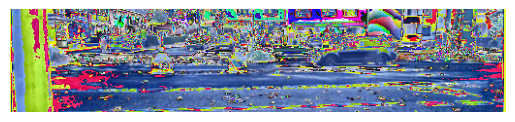

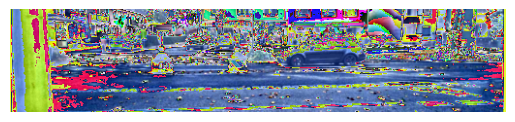

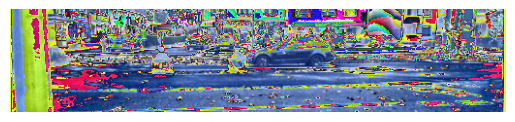

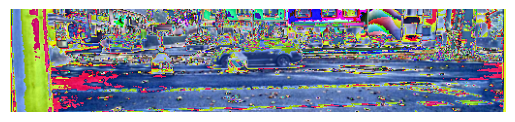

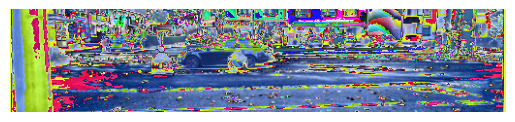

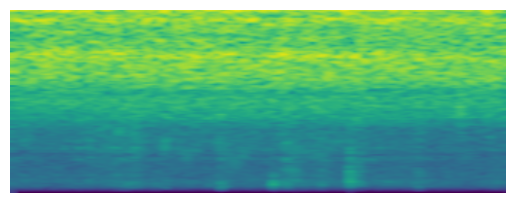

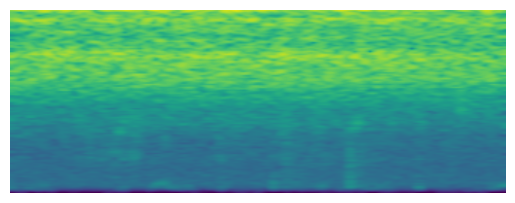

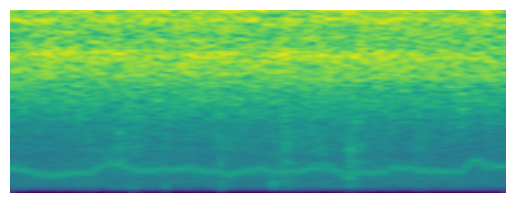

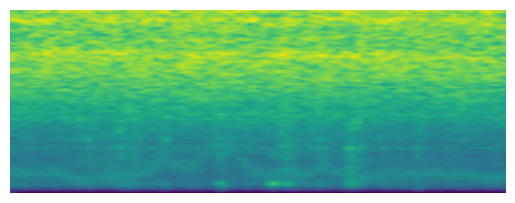

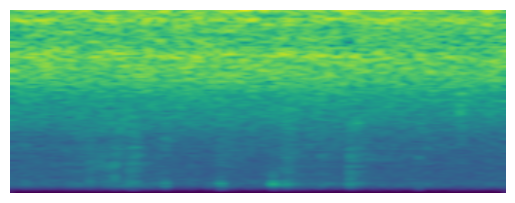

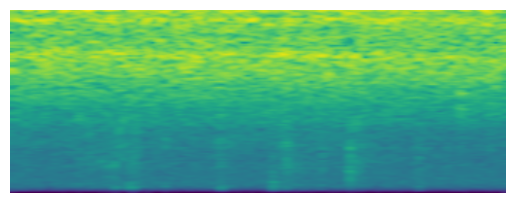

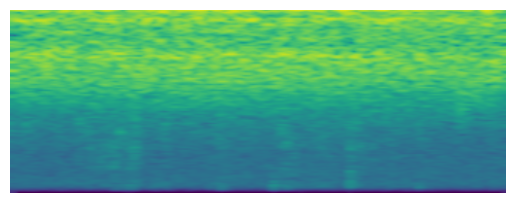

In [10]:
for images, spectrograms, labels in train_dataloader:
    # Your training loop here
    image_0 = images[0]
    image_1 = images[1]
    image_2 = images[2]
    image_3 = images[3]
    image_4 = images[4]

    spec_0 = spectrograms[0]
    spec_1 = spectrograms[1]
    spec_2 = spectrograms[2]
    spec_3 = spectrograms[3]
    spec_4 = spectrograms[4]
    spec_5 = spectrograms[5]
    spec_6 = spectrograms[6]

    visualize_tensor(image_0)
    visualize_tensor(image_1)
    visualize_tensor(image_2)
    visualize_tensor(image_3)
    visualize_tensor(image_4)

    visualize_tensor(spec_0)
    visualize_tensor(spec_1)
    visualize_tensor(spec_2)
    visualize_tensor(spec_3)
    visualize_tensor(spec_4)
    visualize_tensor(spec_5)
    visualize_tensor(spec_6)
    break

In [11]:
class ImageFeatureExtractor(nn.Module):
    def __init__(self, output_features):
        super(ImageFeatureExtractor, self).__init__()
        resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.features = nn.Sequential(*list(resnet50.children())[:-1])  # Remove the last layer

        # Freeze the parameters in the feature extraction layers
        for param in self.features.parameters():
            param.requires_grad = False

        self.fc = nn.Linear(resnet50.fc.in_features, output_features)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x
    
class AudioFeatureExtractor(nn.Module):
    def __init__(self, output_features):
        super(AudioFeatureExtractor, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(64 * 23 * 64, output_features)  # Adjust the size based on your input dimensions

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x
    
class CombinedModel(nn.Module):
    def __init__(self, image_output_features, audio_output_features, num_classes):
        super(CombinedModel, self).__init__()
        self.image_extractor = ImageFeatureExtractor(image_output_features)
        self.audio_extractor = AudioFeatureExtractor(audio_output_features)

        # Combine features from both extractors
        total_features = image_output_features * 5 + audio_output_features * 7
        self.classifier = nn.Linear(total_features, num_classes)

    def forward(self, image_0, image_1, image_2, image_3, image_4,
        audio_0, audio_1, audio_2, audio_3, audio_4, audio_5, audio_6
    ):
        image_features_0 = self.image_extractor(image_0)
        image_features_1 = self.image_extractor(image_1)
        image_features_2 = self.image_extractor(image_2)
        image_features_3 = self.image_extractor(image_3)
        image_features_4 = self.image_extractor(image_4)

        audio_features_0 = self.audio_extractor(audio_0)
        audio_features_1 = self.audio_extractor(audio_1)
        audio_features_2 = self.audio_extractor(audio_2)
        audio_features_3 = self.audio_extractor(audio_3)
        audio_features_4 = self.audio_extractor(audio_4)
        audio_features_5 = self.audio_extractor(audio_5)
        audio_features_6 = self.audio_extractor(audio_6)
        
        combined_features = torch.cat((
            image_features_0, image_features_1, image_features_2, image_features_3, image_features_4,
            audio_features_0, audio_features_1, audio_features_2, audio_features_3, audio_features_4,
            audio_features_5, audio_features_6
        ), dim=1)
        output = self.classifier(combined_features)
        return output

In [12]:
image_output_features = 512 # Adjust as needed
audio_output_features = 256  # Adjust as needed
num_classes = 2  # Adjust based on your dataset

model = CombinedModel(image_output_features, audio_output_features, num_classes)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Learning rate can be adjusted
criterion = nn.CrossEntropyLoss()

In [13]:
num_epochs = 20  # Number of epochs can be adjusted
train_metrics = []
val_metrics = []
best_score = 0

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_running_loss = 0.0
    train_TP = 0
    train_FP = 0
    train_FN = 0
    train_TN = 0

    loop = tqdm(train_dataloader, leave=True)
    for i, (images, spectrograms, labels) in enumerate(loop):     
        # Zero the parameter gradients
        optimizer.zero_grad()

        image_0 = images[0].to(device)
        image_1 = images[1].to(device)
        image_2 = images[2].to(device)
        image_3 = images[3].to(device)
        image_4 = images[4].to(device)

        spec_0 = spectrograms[0].to(device)
        spec_1 = spectrograms[1].to(device)
        spec_2 = spectrograms[2].to(device)
        spec_3 = spectrograms[3].to(device)
        spec_4 = spectrograms[4].to(device)
        spec_5 = spectrograms[5].to(device)
        spec_6 = spectrograms[6].to(device)

        # Forward pass
        outputs = model(
            image_0, image_1, image_2, image_3, image_4,
            spec_0, spec_1, spec_2, spec_3, spec_4, spec_5, spec_6
        )

        # Convert labels and predictions to boolean values if they're not already
        labels_bool = labels.bool()
        outputs = outputs.cpu()
        _, predicted_classes = torch.max(outputs, 1)

        train_TP += ((predicted_classes == 1) & (labels_bool == 1)).sum().item()
        train_FP += ((predicted_classes == 1) & (labels_bool == 0)).sum().item()
        train_FN += ((predicted_classes == 0) & (labels_bool == 1)).sum().item()
        train_TN += ((predicted_classes == 0) & (labels_bool == 0)).sum().item()

        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        train_running_loss += loss.item()
        if i % 10 == 9:    # Print every 10 mini-batches
            accuracy = (train_TP + train_TN) / (train_TP + train_FP + train_FN + train_TN)
            recall = train_TP / (train_TP + train_FN) if (train_TP + train_FN) > 0 else 0
            iou = train_TP / (train_TP + train_FP + train_FN) if (train_TP + train_FP + train_FN) > 0 else 0
            
            print(f"[Epoch: {epoch + 1}, Batch: {i + 1}] Loss: {train_running_loss / 10:.4f}, "
                  f"Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, IoU: {iou:.4f}")
            
            metric = {
                "loss": train_running_loss / 10,
                "accuracy": accuracy,
                "recall": recall,
                "iou": iou,
                "TP": train_TP,
                "FP": train_FP,
                "TN": train_TN,
                "FN": train_FN,
            }

            train_metrics.append(metric)

            train_running_loss = 0.0
            train_TP = 0
            train_FP = 0
            train_FN = 0
            train_TN = 0

            with open(f'{MODEL_DIR}/training_metrics.json', 'w') as f:
                json.dump(train_metrics, f, indent=4)
    
    with torch.no_grad():
        model.eval()  # Set the model to training mode
        val_loss = 0.0
        val_TP = 0
        val_FP = 0
        val_FN = 0
        val_TN = 0

        loop = tqdm(val_dataloader, leave=True)
        k = 0
        for i, (images, spectrograms, labels) in enumerate(loop):     
            image_0 = images[0].to(device)
            image_1 = images[1].to(device)
            image_2 = images[2].to(device)
            image_3 = images[3].to(device)
            image_4 = images[4].to(device)

            spec_0 = spectrograms[0].to(device)
            spec_1 = spectrograms[1].to(device)
            spec_2 = spectrograms[2].to(device)
            spec_3 = spectrograms[3].to(device)
            spec_4 = spectrograms[4].to(device)
            spec_5 = spectrograms[5].to(device)
            spec_6 = spectrograms[6].to(device)

            # Forward pass
            outputs = model(
                image_0, image_1, image_2, image_3, image_4,
                spec_0, spec_1, spec_2, spec_3, spec_4, spec_5, spec_6
            )

            outputs = outputs.cpu()

            loss = criterion(outputs, labels)
            val_loss += loss.item()
            k += 1

            # Convert labels and predictions to boolean values if they're not already
            labels_bool = labels.bool()
            outputs = outputs.cpu()
            _, predicted_classes = torch.max(outputs, 1)

            val_TP += ((predicted_classes == 1) & (labels_bool == 1)).sum().item()
            val_FP += ((predicted_classes == 1) & (labels_bool == 0)).sum().item()
            val_FN += ((predicted_classes == 0) & (labels_bool == 1)).sum().item()
            val_TN += ((predicted_classes == 0) & (labels_bool == 0)).sum().item()
        
        accuracy = (val_TP + val_TN) / (val_TP + val_FP + val_FN + val_TN)
        recall = val_TP / (val_TP + val_FN) if (val_TP + val_FN) > 0 else 0
        iou = val_TP / (val_TP + val_FP + val_FN) if (val_TP + val_FP + val_FN) > 0 else 0
        val_loss = val_loss / k

        metric = {
            "loss": val_loss,
            "accuracy": accuracy,
            "recall": recall,
            "iou": iou,
            "TP": val_TP,
            "FP": val_FP,
            "TN": val_TN,
            "FN": val_FN,
        }

        val_metrics.append(metric)

        with open(f'{MODEL_DIR}/val_metrics.json', 'w') as f:
            json.dump(val_metrics, f, indent=4)

        if (iou > best_score):
            best_score = iou
            torch.save(model, f'{MODEL_DIR}/best_model_epoch_{epoch + 1}.pth')

        print(f"[Val Epoch: {epoch + 1}] Loss: {val_loss:.4f}, "
                  f"Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, IoU: {iou:.4f}")

print("Finished Training")

 12%|█▏        | 10/86 [00:27<03:21,  2.65s/it]

[Epoch: 1, Batch: 10] Loss: 2.7841, Accuracy: 0.5281, Recall: 0.1957, IoU: 0.1517


 23%|██▎       | 20/86 [00:53<02:53,  2.63s/it]

[Epoch: 1, Batch: 20] Loss: 0.6784, Accuracy: 0.5656, Recall: 0.5248, IoU: 0.3474


 35%|███▍      | 30/86 [01:19<02:30,  2.69s/it]

[Epoch: 1, Batch: 30] Loss: 0.3444, Accuracy: 0.8625, Recall: 0.8231, IoU: 0.7333


 47%|████▋     | 40/86 [01:45<01:59,  2.59s/it]

[Epoch: 1, Batch: 40] Loss: 0.4284, Accuracy: 0.8438, Recall: 0.7574, IoU: 0.6732


 58%|█████▊    | 50/86 [02:11<01:32,  2.57s/it]

[Epoch: 1, Batch: 50] Loss: 0.3685, Accuracy: 0.8313, Recall: 0.8148, IoU: 0.7097


 70%|██████▉   | 60/86 [02:37<01:08,  2.63s/it]

[Epoch: 1, Batch: 60] Loss: 0.1975, Accuracy: 0.9375, Recall: 0.9133, IoU: 0.8726


 81%|████████▏ | 70/86 [03:03<00:41,  2.58s/it]

[Epoch: 1, Batch: 70] Loss: 0.1930, Accuracy: 0.9313, Recall: 0.9193, IoU: 0.8706


 93%|█████████▎| 80/86 [03:29<00:15,  2.60s/it]

[Epoch: 1, Batch: 80] Loss: 0.1787, Accuracy: 0.9313, Recall: 0.8889, IoU: 0.8451


100%|██████████| 25/25 [01:03<00:00,  2.55s/it]


[Val Epoch: 1] Loss: 0.2048, Accuracy: 0.9036, Recall: 0.8202, IoU: 0.7956


 12%|█▏        | 10/86 [00:26<03:19,  2.63s/it]

[Epoch: 2, Batch: 10] Loss: 0.1521, Accuracy: 0.9437, Recall: 0.9078, IoU: 0.8767


 23%|██▎       | 20/86 [00:52<02:51,  2.60s/it]

[Epoch: 2, Batch: 20] Loss: 0.2169, Accuracy: 0.9031, Recall: 0.8527, IoU: 0.7801


 35%|███▍      | 30/86 [01:17<02:24,  2.58s/it]

[Epoch: 2, Batch: 30] Loss: 0.1621, Accuracy: 0.9469, Recall: 0.9226, IoU: 0.8938


 47%|████▋     | 40/86 [01:43<01:57,  2.55s/it]

[Epoch: 2, Batch: 40] Loss: 0.1557, Accuracy: 0.9406, Recall: 0.9197, IoU: 0.8690


 58%|█████▊    | 50/86 [02:09<01:33,  2.61s/it]

[Epoch: 2, Batch: 50] Loss: 0.2562, Accuracy: 0.9062, Recall: 0.8750, IoU: 0.8160


 70%|██████▉   | 60/86 [02:35<01:06,  2.57s/it]

[Epoch: 2, Batch: 60] Loss: 0.1977, Accuracy: 0.9187, Recall: 0.9060, IoU: 0.8385


 81%|████████▏ | 70/86 [03:01<00:42,  2.63s/it]

[Epoch: 2, Batch: 70] Loss: 0.1466, Accuracy: 0.9437, Recall: 0.9396, IoU: 0.8861


 93%|█████████▎| 80/86 [03:26<00:15,  2.54s/it]

[Epoch: 2, Batch: 80] Loss: 0.1379, Accuracy: 0.9500, Recall: 0.9034, IoU: 0.8912


100%|██████████| 25/25 [01:01<00:00,  2.47s/it]


[Val Epoch: 2] Loss: 0.1657, Accuracy: 0.9280, Recall: 0.8680, IoU: 0.8466


 12%|█▏        | 10/86 [00:25<03:16,  2.58s/it]

[Epoch: 3, Batch: 10] Loss: 0.0751, Accuracy: 0.9875, Recall: 0.9790, IoU: 0.9722


 23%|██▎       | 20/86 [00:51<02:49,  2.56s/it]

[Epoch: 3, Batch: 20] Loss: 0.1042, Accuracy: 0.9625, Recall: 0.9267, IoU: 0.9205


 35%|███▍      | 30/86 [01:16<02:23,  2.56s/it]

[Epoch: 3, Batch: 30] Loss: 0.1226, Accuracy: 0.9594, Recall: 0.9487, IoU: 0.9193


 47%|████▋     | 40/86 [01:42<01:57,  2.55s/it]

[Epoch: 3, Batch: 40] Loss: 0.1044, Accuracy: 0.9469, Recall: 0.9225, IoU: 0.8750


 58%|█████▊    | 50/86 [02:07<01:30,  2.51s/it]

[Epoch: 3, Batch: 50] Loss: 0.0840, Accuracy: 0.9719, Recall: 0.9424, IoU: 0.9357


 70%|██████▉   | 60/86 [02:32<01:05,  2.52s/it]

[Epoch: 3, Batch: 60] Loss: 0.1013, Accuracy: 0.9531, Recall: 0.9366, IoU: 0.8986


 81%|████████▏ | 70/86 [02:58<00:40,  2.56s/it]

[Epoch: 3, Batch: 70] Loss: 0.1155, Accuracy: 0.9500, Recall: 0.9412, IoU: 0.8889


 93%|█████████▎| 80/86 [03:23<00:15,  2.54s/it]

[Epoch: 3, Batch: 80] Loss: 0.1217, Accuracy: 0.9563, Recall: 0.9636, IoU: 0.9191


100%|██████████| 25/25 [01:01<00:00,  2.48s/it]


[Val Epoch: 3] Loss: 0.1708, Accuracy: 0.9332, Recall: 0.9607, IoU: 0.8680


 12%|█▏        | 10/86 [00:25<03:15,  2.57s/it]

[Epoch: 4, Batch: 10] Loss: 0.0962, Accuracy: 0.9719, Recall: 0.9645, IoU: 0.9379


 23%|██▎       | 20/86 [00:51<02:49,  2.57s/it]

[Epoch: 4, Batch: 20] Loss: 0.0948, Accuracy: 0.9656, Recall: 0.9589, IoU: 0.9272


 35%|███▍      | 30/86 [01:17<02:23,  2.56s/it]

[Epoch: 4, Batch: 30] Loss: 0.0398, Accuracy: 0.9906, Recall: 0.9860, IoU: 0.9792


 47%|████▋     | 40/86 [01:42<01:58,  2.57s/it]

[Epoch: 4, Batch: 40] Loss: 0.1249, Accuracy: 0.9531, Recall: 0.9530, IoU: 0.9045


 58%|█████▊    | 50/86 [02:08<01:31,  2.55s/it]

[Epoch: 4, Batch: 50] Loss: 0.1244, Accuracy: 0.9563, Recall: 0.9362, IoU: 0.9041


 70%|██████▉   | 60/86 [02:33<01:06,  2.54s/it]

[Epoch: 4, Batch: 60] Loss: 0.1220, Accuracy: 0.9563, Recall: 0.9481, IoU: 0.9125


 81%|████████▏ | 70/86 [02:59<00:41,  2.58s/it]

[Epoch: 4, Batch: 70] Loss: 0.1671, Accuracy: 0.9313, Recall: 0.9067, IoU: 0.8608


 93%|█████████▎| 80/86 [03:25<00:15,  2.66s/it]

[Epoch: 4, Batch: 80] Loss: 0.1641, Accuracy: 0.9375, Recall: 0.9071, IoU: 0.8639


100%|██████████| 25/25 [01:02<00:00,  2.50s/it]


[Val Epoch: 4] Loss: 0.1675, Accuracy: 0.9383, Recall: 0.8820, IoU: 0.8674


 12%|█▏        | 10/86 [00:25<03:14,  2.55s/it]

[Epoch: 5, Batch: 10] Loss: 0.0829, Accuracy: 0.9625, Recall: 0.9267, IoU: 0.9205


 23%|██▎       | 20/86 [00:50<02:45,  2.51s/it]

[Epoch: 5, Batch: 20] Loss: 0.0563, Accuracy: 0.9781, Recall: 0.9695, IoU: 0.9578


 35%|███▍      | 30/86 [01:16<02:22,  2.55s/it]

[Epoch: 5, Batch: 30] Loss: 0.0512, Accuracy: 0.9875, Recall: 0.9701, IoU: 0.9701


 47%|████▋     | 40/86 [01:41<01:55,  2.51s/it]

[Epoch: 5, Batch: 40] Loss: 0.0530, Accuracy: 0.9781, Recall: 0.9638, IoU: 0.9500


 58%|█████▊    | 50/86 [02:07<01:31,  2.55s/it]

[Epoch: 5, Batch: 50] Loss: 0.0898, Accuracy: 0.9688, Recall: 0.9600, IoU: 0.9351


 70%|██████▉   | 60/86 [02:32<01:07,  2.61s/it]

[Epoch: 5, Batch: 60] Loss: 0.0657, Accuracy: 0.9719, Recall: 0.9638, IoU: 0.9366


 81%|████████▏ | 70/86 [02:58<00:41,  2.57s/it]

[Epoch: 5, Batch: 70] Loss: 0.0330, Accuracy: 0.9844, Recall: 0.9793, IoU: 0.9660


 93%|█████████▎| 80/86 [03:24<00:15,  2.55s/it]

[Epoch: 5, Batch: 80] Loss: 0.0820, Accuracy: 0.9719, Recall: 0.9565, IoU: 0.9362


100%|██████████| 25/25 [01:01<00:00,  2.47s/it]


[Val Epoch: 5] Loss: 0.1334, Accuracy: 0.9512, Recall: 0.9213, IoU: 0.8962


 12%|█▏        | 10/86 [00:25<03:13,  2.55s/it]

[Epoch: 6, Batch: 10] Loss: 0.0560, Accuracy: 0.9719, Recall: 0.9586, IoU: 0.9392


 23%|██▎       | 20/86 [00:51<02:49,  2.56s/it]

[Epoch: 6, Batch: 20] Loss: 0.0325, Accuracy: 0.9875, Recall: 0.9786, IoU: 0.9716


 35%|███▍      | 30/86 [01:16<02:24,  2.58s/it]

[Epoch: 6, Batch: 30] Loss: 0.0693, Accuracy: 0.9750, Recall: 0.9728, IoU: 0.9470


 47%|████▋     | 40/86 [01:42<01:57,  2.55s/it]

[Epoch: 6, Batch: 40] Loss: 0.0486, Accuracy: 0.9844, Recall: 0.9786, IoU: 0.9648


 58%|█████▊    | 50/86 [02:08<01:33,  2.59s/it]

[Epoch: 6, Batch: 50] Loss: 0.0668, Accuracy: 0.9688, Recall: 0.9530, IoU: 0.9342


 70%|██████▉   | 60/86 [02:33<01:05,  2.53s/it]

[Epoch: 6, Batch: 60] Loss: 0.0401, Accuracy: 0.9875, Recall: 0.9873, IoU: 0.9748


 81%|████████▏ | 70/86 [02:59<00:40,  2.54s/it]

[Epoch: 6, Batch: 70] Loss: 0.0198, Accuracy: 0.9969, Recall: 0.9928, IoU: 0.9928


 93%|█████████▎| 80/86 [03:24<00:15,  2.54s/it]

[Epoch: 6, Batch: 80] Loss: 0.0420, Accuracy: 0.9875, Recall: 0.9862, IoU: 0.9728


100%|██████████| 25/25 [01:01<00:00,  2.47s/it]


[Val Epoch: 6] Loss: 0.1778, Accuracy: 0.9550, Recall: 0.9382, IoU: 0.9051


 12%|█▏        | 10/86 [00:25<03:10,  2.51s/it]

[Epoch: 7, Batch: 10] Loss: 0.0390, Accuracy: 0.9844, Recall: 0.9808, IoU: 0.9684


 23%|██▎       | 20/86 [00:50<02:48,  2.55s/it]

[Epoch: 7, Batch: 20] Loss: 0.0168, Accuracy: 0.9938, Recall: 0.9935, IoU: 0.9870


 35%|███▍      | 30/86 [01:16<02:22,  2.54s/it]

[Epoch: 7, Batch: 30] Loss: 0.0513, Accuracy: 0.9844, Recall: 0.9699, IoU: 0.9627


 47%|████▋     | 40/86 [01:41<01:57,  2.55s/it]

[Epoch: 7, Batch: 40] Loss: 0.0816, Accuracy: 0.9719, Recall: 0.9660, IoU: 0.9404


 58%|█████▊    | 50/86 [02:07<01:32,  2.57s/it]

[Epoch: 7, Batch: 50] Loss: 0.0350, Accuracy: 0.9938, Recall: 1.0000, IoU: 0.9866


 70%|██████▉   | 60/86 [02:32<01:06,  2.55s/it]

[Epoch: 7, Batch: 60] Loss: 0.0179, Accuracy: 0.9938, Recall: 0.9865, IoU: 0.9865


 81%|████████▏ | 70/86 [02:58<00:40,  2.55s/it]

[Epoch: 7, Batch: 70] Loss: 0.0101, Accuracy: 1.0000, Recall: 1.0000, IoU: 1.0000


 93%|█████████▎| 80/86 [03:23<00:15,  2.55s/it]

[Epoch: 7, Batch: 80] Loss: 0.0196, Accuracy: 0.9969, Recall: 0.9929, IoU: 0.9929


100%|██████████| 25/25 [01:01<00:00,  2.47s/it]


[Val Epoch: 7] Loss: 0.1573, Accuracy: 0.9473, Recall: 0.9663, IoU: 0.8935


 12%|█▏        | 10/86 [00:25<03:11,  2.53s/it]

[Epoch: 8, Batch: 10] Loss: 0.0324, Accuracy: 0.9938, Recall: 0.9858, IoU: 0.9858


 23%|██▎       | 20/86 [00:51<02:51,  2.59s/it]

[Epoch: 8, Batch: 20] Loss: 0.0301, Accuracy: 0.9906, Recall: 0.9853, IoU: 0.9781


 35%|███▍      | 30/86 [01:16<02:22,  2.55s/it]

[Epoch: 8, Batch: 30] Loss: 0.0321, Accuracy: 0.9906, Recall: 0.9862, IoU: 0.9795


 47%|████▋     | 40/86 [01:42<01:57,  2.55s/it]

[Epoch: 8, Batch: 40] Loss: 0.0420, Accuracy: 0.9812, Recall: 0.9783, IoU: 0.9574


 58%|█████▊    | 50/86 [02:07<01:31,  2.53s/it]

[Epoch: 8, Batch: 50] Loss: 0.0784, Accuracy: 0.9781, Recall: 0.9658, IoU: 0.9527


 70%|██████▉   | 60/86 [02:33<01:06,  2.55s/it]

[Epoch: 8, Batch: 60] Loss: 0.0754, Accuracy: 0.9750, Recall: 0.9718, IoU: 0.9452


 81%|████████▏ | 70/86 [02:58<00:40,  2.56s/it]

[Epoch: 8, Batch: 70] Loss: 0.0694, Accuracy: 0.9781, Recall: 0.9800, IoU: 0.9545


 93%|█████████▎| 80/86 [03:24<00:15,  2.52s/it]

[Epoch: 8, Batch: 80] Loss: 0.0462, Accuracy: 0.9812, Recall: 0.9811, IoU: 0.9630


100%|██████████| 25/25 [01:02<00:00,  2.48s/it]


[Val Epoch: 8] Loss: 0.1926, Accuracy: 0.9383, Recall: 0.9101, IoU: 0.8710


 12%|█▏        | 10/86 [00:25<03:10,  2.50s/it]

[Epoch: 9, Batch: 10] Loss: 0.0389, Accuracy: 0.9844, Recall: 0.9844, IoU: 0.9618


 23%|██▎       | 20/86 [00:50<02:48,  2.56s/it]

[Epoch: 9, Batch: 20] Loss: 0.0351, Accuracy: 0.9844, Recall: 0.9803, IoU: 0.9675


 35%|███▍      | 30/86 [01:16<02:22,  2.54s/it]

[Epoch: 9, Batch: 30] Loss: 0.0346, Accuracy: 0.9844, Recall: 0.9796, IoU: 0.9664


 47%|████▋     | 40/86 [01:41<01:57,  2.54s/it]

[Epoch: 9, Batch: 40] Loss: 0.0254, Accuracy: 0.9938, Recall: 0.9934, IoU: 0.9869


 58%|█████▊    | 50/86 [02:07<01:31,  2.54s/it]

[Epoch: 9, Batch: 50] Loss: 0.0685, Accuracy: 0.9719, Recall: 0.9653, IoU: 0.9392


 70%|██████▉   | 60/86 [02:33<01:06,  2.56s/it]

[Epoch: 9, Batch: 60] Loss: 0.0712, Accuracy: 0.9844, Recall: 0.9716, IoU: 0.9648


 81%|████████▏ | 70/86 [02:58<00:40,  2.53s/it]

[Epoch: 9, Batch: 70] Loss: 0.0472, Accuracy: 0.9844, Recall: 0.9864, IoU: 0.9667


 93%|█████████▎| 80/86 [03:23<00:15,  2.55s/it]

[Epoch: 9, Batch: 80] Loss: 0.0252, Accuracy: 0.9938, Recall: 0.9868, IoU: 0.9868


100%|██████████| 25/25 [01:02<00:00,  2.48s/it]


[Val Epoch: 9] Loss: 0.2404, Accuracy: 0.9267, Recall: 0.8680, IoU: 0.8443


 12%|█▏        | 10/86 [00:25<03:14,  2.56s/it]

[Epoch: 10, Batch: 10] Loss: 0.0702, Accuracy: 0.9781, Recall: 0.9632, IoU: 0.9493


 23%|██▎       | 20/86 [00:51<02:50,  2.58s/it]

[Epoch: 10, Batch: 20] Loss: 0.0307, Accuracy: 0.9906, Recall: 0.9811, IoU: 0.9811


 35%|███▍      | 30/86 [01:16<02:22,  2.54s/it]

[Epoch: 10, Batch: 30] Loss: 0.0291, Accuracy: 0.9906, Recall: 1.0000, IoU: 0.9790


 47%|████▋     | 40/86 [01:42<01:58,  2.57s/it]

[Epoch: 10, Batch: 40] Loss: 0.0163, Accuracy: 1.0000, Recall: 1.0000, IoU: 1.0000


 58%|█████▊    | 50/86 [02:07<01:31,  2.55s/it]

[Epoch: 10, Batch: 50] Loss: 0.0234, Accuracy: 0.9938, Recall: 0.9932, IoU: 0.9866


 70%|██████▉   | 60/86 [02:33<01:06,  2.57s/it]

[Epoch: 10, Batch: 60] Loss: 0.0678, Accuracy: 0.9750, Recall: 0.9732, IoU: 0.9477


 81%|████████▏ | 70/86 [02:58<00:40,  2.54s/it]

[Epoch: 10, Batch: 70] Loss: 0.0299, Accuracy: 0.9844, Recall: 0.9645, IoU: 0.9645


 93%|█████████▎| 80/86 [03:24<00:15,  2.54s/it]

[Epoch: 10, Batch: 80] Loss: 0.0312, Accuracy: 0.9844, Recall: 0.9931, IoU: 0.9662


100%|██████████| 25/25 [01:02<00:00,  2.48s/it]


[Val Epoch: 10] Loss: 0.3502, Accuracy: 0.9087, Recall: 0.9775, IoU: 0.8305


 12%|█▏        | 10/86 [00:25<03:12,  2.53s/it]

[Epoch: 11, Batch: 10] Loss: 0.0173, Accuracy: 0.9969, Recall: 1.0000, IoU: 0.9930


 23%|██▎       | 20/86 [00:50<02:48,  2.56s/it]

[Epoch: 11, Batch: 20] Loss: 0.0167, Accuracy: 0.9938, Recall: 0.9931, IoU: 0.9862


 35%|███▍      | 30/86 [01:16<02:22,  2.55s/it]

[Epoch: 11, Batch: 30] Loss: 0.0274, Accuracy: 0.9906, Recall: 0.9852, IoU: 0.9779


 47%|████▋     | 40/86 [01:41<01:56,  2.54s/it]

[Epoch: 11, Batch: 40] Loss: 0.0302, Accuracy: 0.9844, Recall: 0.9712, IoU: 0.9643


 58%|█████▊    | 50/86 [02:07<01:31,  2.54s/it]

[Epoch: 11, Batch: 50] Loss: 0.0768, Accuracy: 0.9688, Recall: 0.9452, IoU: 0.9324


 70%|██████▉   | 60/86 [02:32<01:05,  2.53s/it]

[Epoch: 11, Batch: 60] Loss: 0.0373, Accuracy: 0.9875, Recall: 0.9933, IoU: 0.9737


 81%|████████▏ | 70/86 [02:57<00:40,  2.51s/it]

[Epoch: 11, Batch: 70] Loss: 0.0395, Accuracy: 0.9906, Recall: 0.9811, IoU: 0.9811


 93%|█████████▎| 80/86 [03:23<00:15,  2.59s/it]

[Epoch: 11, Batch: 80] Loss: 0.0339, Accuracy: 0.9781, Recall: 0.9653, IoU: 0.9521


100%|██████████| 25/25 [01:01<00:00,  2.46s/it]


[Val Epoch: 11] Loss: 0.1455, Accuracy: 0.9524, Recall: 0.9522, IoU: 0.9016


 12%|█▏        | 10/86 [00:25<03:14,  2.55s/it]

[Epoch: 12, Batch: 10] Loss: 0.0369, Accuracy: 0.9906, Recall: 0.9862, IoU: 0.9795


 23%|██▎       | 20/86 [00:51<02:48,  2.56s/it]

[Epoch: 12, Batch: 20] Loss: 0.0219, Accuracy: 0.9906, Recall: 0.9877, IoU: 0.9817


 35%|███▍      | 30/86 [01:16<02:21,  2.52s/it]

[Epoch: 12, Batch: 30] Loss: 0.0141, Accuracy: 1.0000, Recall: 1.0000, IoU: 1.0000


 47%|████▋     | 40/86 [01:41<01:56,  2.52s/it]

[Epoch: 12, Batch: 40] Loss: 0.0109, Accuracy: 0.9969, Recall: 0.9928, IoU: 0.9928


 58%|█████▊    | 50/86 [02:07<01:30,  2.53s/it]

[Epoch: 12, Batch: 50] Loss: 0.0238, Accuracy: 0.9938, Recall: 0.9929, IoU: 0.9858


 70%|██████▉   | 60/86 [02:32<01:06,  2.56s/it]

[Epoch: 12, Batch: 60] Loss: 0.0198, Accuracy: 0.9875, Recall: 0.9708, IoU: 0.9708


 81%|████████▏ | 70/86 [02:58<00:40,  2.55s/it]

[Epoch: 12, Batch: 70] Loss: 0.0943, Accuracy: 0.9656, Recall: 0.9600, IoU: 0.9290


 93%|█████████▎| 80/86 [03:23<00:15,  2.57s/it]

[Epoch: 12, Batch: 80] Loss: 0.0450, Accuracy: 0.9812, Recall: 0.9848, IoU: 0.9559


100%|██████████| 25/25 [01:01<00:00,  2.48s/it]


[Val Epoch: 12] Loss: 0.2166, Accuracy: 0.9280, Recall: 0.9860, IoU: 0.8624


 12%|█▏        | 10/86 [00:25<03:12,  2.53s/it]

[Epoch: 13, Batch: 10] Loss: 0.0148, Accuracy: 0.9969, Recall: 1.0000, IoU: 0.9929


 23%|██▎       | 20/86 [00:51<02:48,  2.55s/it]

[Epoch: 13, Batch: 20] Loss: 0.0168, Accuracy: 0.9906, Recall: 0.9790, IoU: 0.9790


 35%|███▍      | 30/86 [01:16<02:23,  2.55s/it]

[Epoch: 13, Batch: 30] Loss: 0.0183, Accuracy: 0.9906, Recall: 1.0000, IoU: 0.9803


 47%|████▋     | 40/86 [01:41<01:55,  2.52s/it]

[Epoch: 13, Batch: 40] Loss: 0.0172, Accuracy: 0.9938, Recall: 0.9848, IoU: 0.9848


 58%|█████▊    | 50/86 [02:07<01:33,  2.59s/it]

[Epoch: 13, Batch: 50] Loss: 0.0216, Accuracy: 0.9844, Recall: 0.9851, IoU: 0.9635


 70%|██████▉   | 60/86 [02:32<01:06,  2.54s/it]

[Epoch: 13, Batch: 60] Loss: 0.0287, Accuracy: 0.9844, Recall: 0.9871, IoU: 0.9684


 81%|████████▏ | 70/86 [02:58<00:40,  2.54s/it]

[Epoch: 13, Batch: 70] Loss: 0.0435, Accuracy: 0.9844, Recall: 0.9747, IoU: 0.9686


 93%|█████████▎| 80/86 [03:24<00:15,  2.55s/it]

[Epoch: 13, Batch: 80] Loss: 0.0235, Accuracy: 0.9875, Recall: 0.9930, IoU: 0.9724


100%|██████████| 25/25 [01:01<00:00,  2.48s/it]


[Val Epoch: 13] Loss: 0.3488, Accuracy: 0.9473, Recall: 0.9466, IoU: 0.8915


 12%|█▏        | 10/86 [00:25<03:14,  2.56s/it]

[Epoch: 14, Batch: 10] Loss: 0.0179, Accuracy: 0.9969, Recall: 1.0000, IoU: 0.9926


 23%|██▎       | 20/86 [00:51<02:47,  2.54s/it]

[Epoch: 14, Batch: 20] Loss: 0.0358, Accuracy: 0.9938, Recall: 0.9861, IoU: 0.9861


 35%|███▍      | 30/86 [01:16<02:22,  2.55s/it]

[Epoch: 14, Batch: 30] Loss: 0.0142, Accuracy: 0.9906, Recall: 1.0000, IoU: 0.9793


 47%|████▋     | 40/86 [01:42<01:58,  2.59s/it]

[Epoch: 14, Batch: 40] Loss: 0.0138, Accuracy: 0.9938, Recall: 0.9868, IoU: 0.9868


 58%|█████▊    | 50/86 [02:07<01:32,  2.57s/it]

[Epoch: 14, Batch: 50] Loss: 0.0042, Accuracy: 1.0000, Recall: 1.0000, IoU: 1.0000


 70%|██████▉   | 60/86 [02:33<01:05,  2.50s/it]

[Epoch: 14, Batch: 60] Loss: 0.0210, Accuracy: 0.9906, Recall: 0.9932, IoU: 0.9797


 81%|████████▏ | 70/86 [02:58<00:41,  2.57s/it]

[Epoch: 14, Batch: 70] Loss: 0.0136, Accuracy: 0.9969, Recall: 0.9930, IoU: 0.9930


 93%|█████████▎| 80/86 [03:24<00:15,  2.54s/it]

[Epoch: 14, Batch: 80] Loss: 0.0154, Accuracy: 0.9938, Recall: 0.9936, IoU: 0.9873


100%|██████████| 25/25 [01:01<00:00,  2.47s/it]


[Val Epoch: 14] Loss: 0.3039, Accuracy: 0.9473, Recall: 0.9438, IoU: 0.8912


 12%|█▏        | 10/86 [00:25<03:13,  2.55s/it]

[Epoch: 15, Batch: 10] Loss: 0.0020, Accuracy: 1.0000, Recall: 1.0000, IoU: 1.0000


 23%|██▎       | 20/86 [00:50<02:47,  2.54s/it]

[Epoch: 15, Batch: 20] Loss: 0.0429, Accuracy: 0.9844, Recall: 0.9710, IoU: 0.9640


 35%|███▍      | 30/86 [01:16<02:25,  2.59s/it]

[Epoch: 15, Batch: 30] Loss: 0.0286, Accuracy: 0.9875, Recall: 0.9934, IoU: 0.9740


 47%|████▋     | 40/86 [01:41<01:56,  2.53s/it]

[Epoch: 15, Batch: 40] Loss: 0.0196, Accuracy: 0.9969, Recall: 0.9931, IoU: 0.9931


 58%|█████▊    | 50/86 [02:07<01:31,  2.55s/it]

[Epoch: 15, Batch: 50] Loss: 0.0634, Accuracy: 0.9781, Recall: 0.9638, IoU: 0.9500


 70%|██████▉   | 60/86 [02:33<01:06,  2.55s/it]

[Epoch: 15, Batch: 60] Loss: 0.0219, Accuracy: 0.9906, Recall: 0.9935, IoU: 0.9809


 81%|████████▏ | 70/86 [02:58<00:40,  2.53s/it]

[Epoch: 15, Batch: 70] Loss: 0.0834, Accuracy: 0.9688, Recall: 0.9720, IoU: 0.9329


 93%|█████████▎| 80/86 [03:24<00:15,  2.53s/it]

[Epoch: 15, Batch: 80] Loss: 0.0304, Accuracy: 0.9844, Recall: 0.9609, IoU: 0.9609


100%|██████████| 25/25 [01:01<00:00,  2.47s/it]


[Val Epoch: 15] Loss: 0.2262, Accuracy: 0.9396, Recall: 0.9747, IoU: 0.8807


 12%|█▏        | 10/86 [00:25<03:13,  2.55s/it]

[Epoch: 16, Batch: 10] Loss: 0.0478, Accuracy: 0.9781, Recall: 0.9690, IoU: 0.9470


 23%|██▎       | 20/86 [00:51<02:49,  2.56s/it]

[Epoch: 16, Batch: 20] Loss: 0.0452, Accuracy: 0.9875, Recall: 0.9864, IoU: 0.9732


 35%|███▍      | 30/86 [01:16<02:21,  2.53s/it]

[Epoch: 16, Batch: 30] Loss: 0.0282, Accuracy: 0.9844, Recall: 0.9643, IoU: 0.9643


 47%|████▋     | 40/86 [01:41<01:58,  2.57s/it]

[Epoch: 16, Batch: 40] Loss: 0.0238, Accuracy: 0.9938, Recall: 1.0000, IoU: 0.9867


 58%|█████▊    | 50/86 [02:07<01:31,  2.53s/it]

[Epoch: 16, Batch: 50] Loss: 0.0220, Accuracy: 0.9938, Recall: 0.9866, IoU: 0.9866


 70%|██████▉   | 60/86 [02:32<01:05,  2.54s/it]

[Epoch: 16, Batch: 60] Loss: 0.0636, Accuracy: 0.9719, Recall: 0.9671, IoU: 0.9423


 81%|████████▏ | 70/86 [02:57<00:41,  2.57s/it]

[Epoch: 16, Batch: 70] Loss: 0.0026, Accuracy: 1.0000, Recall: 1.0000, IoU: 1.0000


 93%|█████████▎| 80/86 [03:23<00:15,  2.54s/it]

[Epoch: 16, Batch: 80] Loss: 0.0193, Accuracy: 0.9938, Recall: 0.9931, IoU: 0.9863


100%|██████████| 25/25 [01:01<00:00,  2.48s/it]


[Val Epoch: 16] Loss: 0.1918, Accuracy: 0.9383, Recall: 0.9017, IoU: 0.8699


 12%|█▏        | 10/86 [00:25<03:13,  2.55s/it]

[Epoch: 17, Batch: 10] Loss: 0.2848, Accuracy: 0.9250, Recall: 0.9054, IoU: 0.8481


 23%|██▎       | 20/86 [00:50<02:48,  2.55s/it]

[Epoch: 17, Batch: 20] Loss: 0.1429, Accuracy: 0.9437, Recall: 0.9527, IoU: 0.8868


 35%|███▍      | 30/86 [01:16<02:21,  2.52s/it]

[Epoch: 17, Batch: 30] Loss: 0.2506, Accuracy: 0.9375, Recall: 0.9172, IoU: 0.8693


 47%|████▋     | 40/86 [01:41<01:59,  2.59s/it]

[Epoch: 17, Batch: 40] Loss: 0.0757, Accuracy: 0.9844, Recall: 0.9630, IoU: 0.9630


 58%|█████▊    | 50/86 [02:07<01:32,  2.57s/it]

[Epoch: 17, Batch: 50] Loss: 0.2326, Accuracy: 0.9437, Recall: 0.9379, IoU: 0.8935


 70%|██████▉   | 60/86 [02:32<01:06,  2.54s/it]

[Epoch: 17, Batch: 60] Loss: 0.1031, Accuracy: 0.9656, Recall: 0.9937, IoU: 0.9345


 81%|████████▏ | 70/86 [02:58<00:40,  2.53s/it]

[Epoch: 17, Batch: 70] Loss: 0.1825, Accuracy: 0.9437, Recall: 0.9254, IoU: 0.8732


 93%|█████████▎| 80/86 [03:23<00:15,  2.53s/it]

[Epoch: 17, Batch: 80] Loss: 0.0523, Accuracy: 0.9875, Recall: 0.9699, IoU: 0.9699


100%|██████████| 25/25 [01:01<00:00,  2.46s/it]


[Val Epoch: 17] Loss: 0.2766, Accuracy: 0.9524, Recall: 0.9157, IoU: 0.8981


 12%|█▏        | 10/86 [00:25<03:14,  2.56s/it]

[Epoch: 18, Batch: 10] Loss: 0.4495, Accuracy: 0.9031, Recall: 0.8897, IoU: 0.8063


 23%|██▎       | 20/86 [00:50<02:46,  2.52s/it]

[Epoch: 18, Batch: 20] Loss: 0.1967, Accuracy: 0.9469, Recall: 0.9379, IoU: 0.8889


 35%|███▍      | 30/86 [01:16<02:23,  2.56s/it]

[Epoch: 18, Batch: 30] Loss: 0.0738, Accuracy: 0.9750, Recall: 0.9600, IoU: 0.9474


 47%|████▋     | 40/86 [01:41<01:57,  2.55s/it]

[Epoch: 18, Batch: 40] Loss: 0.0190, Accuracy: 0.9969, Recall: 1.0000, IoU: 0.9925


 58%|█████▊    | 50/86 [02:06<01:31,  2.53s/it]

[Epoch: 18, Batch: 50] Loss: 0.0401, Accuracy: 0.9844, Recall: 0.9737, IoU: 0.9673


 70%|██████▉   | 60/86 [02:32<01:06,  2.57s/it]

[Epoch: 18, Batch: 60] Loss: 0.0167, Accuracy: 0.9938, Recall: 0.9933, IoU: 0.9867


 81%|████████▏ | 70/86 [02:57<00:40,  2.56s/it]

[Epoch: 18, Batch: 70] Loss: 0.0480, Accuracy: 0.9906, Recall: 0.9783, IoU: 0.9783


 93%|█████████▎| 80/86 [03:23<00:15,  2.51s/it]

[Epoch: 18, Batch: 80] Loss: 0.0363, Accuracy: 0.9875, Recall: 0.9933, IoU: 0.9737


100%|██████████| 25/25 [01:01<00:00,  2.47s/it]


[Val Epoch: 18] Loss: 0.4154, Accuracy: 0.9524, Recall: 0.9270, IoU: 0.8992


 12%|█▏        | 10/86 [00:25<03:17,  2.60s/it]

[Epoch: 19, Batch: 10] Loss: 0.0016, Accuracy: 1.0000, Recall: 1.0000, IoU: 1.0000


 23%|██▎       | 20/86 [00:51<02:48,  2.55s/it]

[Epoch: 19, Batch: 20] Loss: 0.0229, Accuracy: 0.9906, Recall: 0.9784, IoU: 0.9784


 35%|███▍      | 30/86 [01:16<02:23,  2.57s/it]

[Epoch: 19, Batch: 30] Loss: 0.0699, Accuracy: 0.9844, Recall: 1.0000, IoU: 0.9667


 47%|████▋     | 40/86 [01:42<01:56,  2.53s/it]

[Epoch: 19, Batch: 40] Loss: 0.0433, Accuracy: 0.9906, Recall: 0.9789, IoU: 0.9789


 58%|█████▊    | 50/86 [02:07<01:31,  2.55s/it]

[Epoch: 19, Batch: 50] Loss: 0.0111, Accuracy: 0.9906, Recall: 1.0000, IoU: 0.9814


 70%|██████▉   | 60/86 [02:33<01:05,  2.52s/it]

[Epoch: 19, Batch: 60] Loss: 0.0510, Accuracy: 0.9875, Recall: 0.9867, IoU: 0.9737


 81%|████████▏ | 70/86 [02:58<00:41,  2.56s/it]

[Epoch: 19, Batch: 70] Loss: 0.0087, Accuracy: 0.9969, Recall: 0.9929, IoU: 0.9929


 93%|█████████▎| 80/86 [03:23<00:15,  2.53s/it]

[Epoch: 19, Batch: 80] Loss: 0.0103, Accuracy: 0.9969, Recall: 1.0000, IoU: 0.9934


100%|██████████| 25/25 [01:01<00:00,  2.47s/it]


[Val Epoch: 19] Loss: 0.4398, Accuracy: 0.9499, Recall: 0.9157, IoU: 0.8932


 12%|█▏        | 10/86 [00:25<03:14,  2.56s/it]

[Epoch: 20, Batch: 10] Loss: 0.0493, Accuracy: 0.9875, Recall: 1.0000, IoU: 0.9704


 23%|██▎       | 20/86 [00:51<02:48,  2.56s/it]

[Epoch: 20, Batch: 20] Loss: 0.0661, Accuracy: 0.9812, Recall: 0.9589, IoU: 0.9589


 35%|███▍      | 30/86 [01:16<02:23,  2.56s/it]

[Epoch: 20, Batch: 30] Loss: 0.0283, Accuracy: 0.9844, Recall: 1.0000, IoU: 0.9658


 47%|████▋     | 40/86 [01:41<01:56,  2.53s/it]

[Epoch: 20, Batch: 40] Loss: 0.0248, Accuracy: 0.9906, Recall: 0.9795, IoU: 0.9795


 58%|█████▊    | 50/86 [02:07<01:31,  2.54s/it]

[Epoch: 20, Batch: 50] Loss: 0.0032, Accuracy: 1.0000, Recall: 1.0000, IoU: 1.0000


 70%|██████▉   | 60/86 [02:32<01:05,  2.54s/it]

[Epoch: 20, Batch: 60] Loss: 0.0342, Accuracy: 0.9906, Recall: 0.9877, IoU: 0.9816


 81%|████████▏ | 70/86 [02:58<00:40,  2.54s/it]

[Epoch: 20, Batch: 70] Loss: 0.0362, Accuracy: 0.9875, Recall: 0.9863, IoU: 0.9730


 93%|█████████▎| 80/86 [03:23<00:15,  2.54s/it]

[Epoch: 20, Batch: 80] Loss: 0.0084, Accuracy: 1.0000, Recall: 1.0000, IoU: 1.0000


100%|██████████| 25/25 [01:01<00:00,  2.46s/it]

[Val Epoch: 20] Loss: 0.5251, Accuracy: 0.9319, Recall: 0.9270, IoU: 0.8616
Finished Training


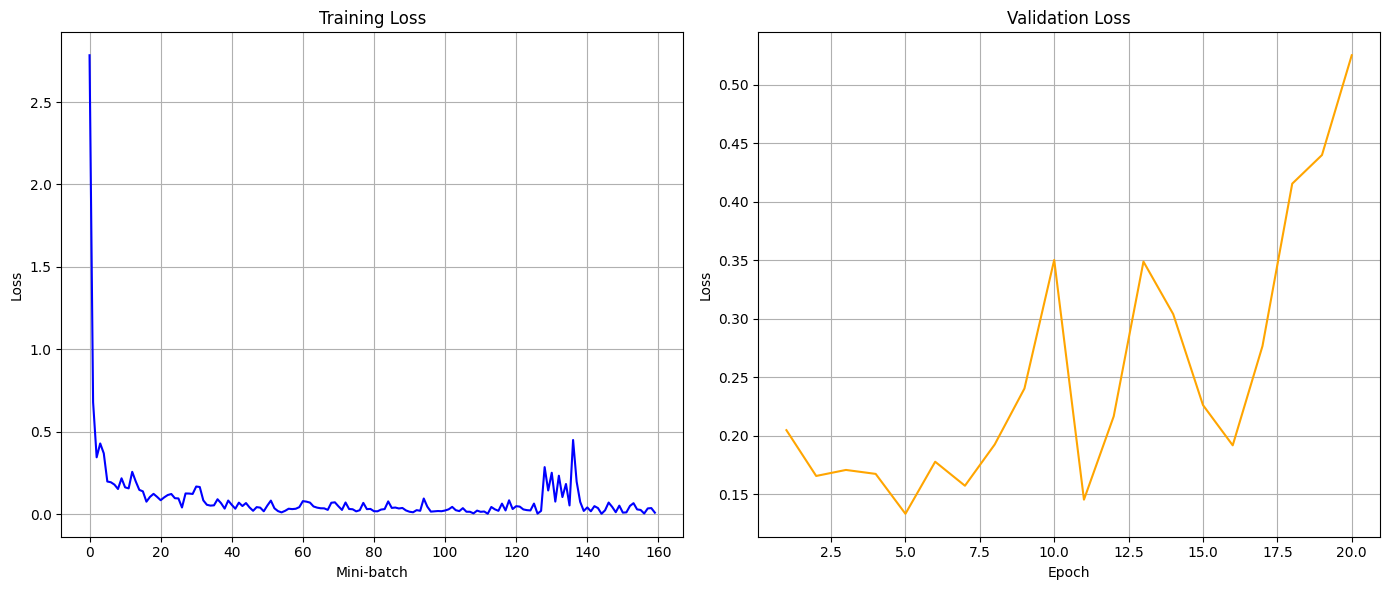

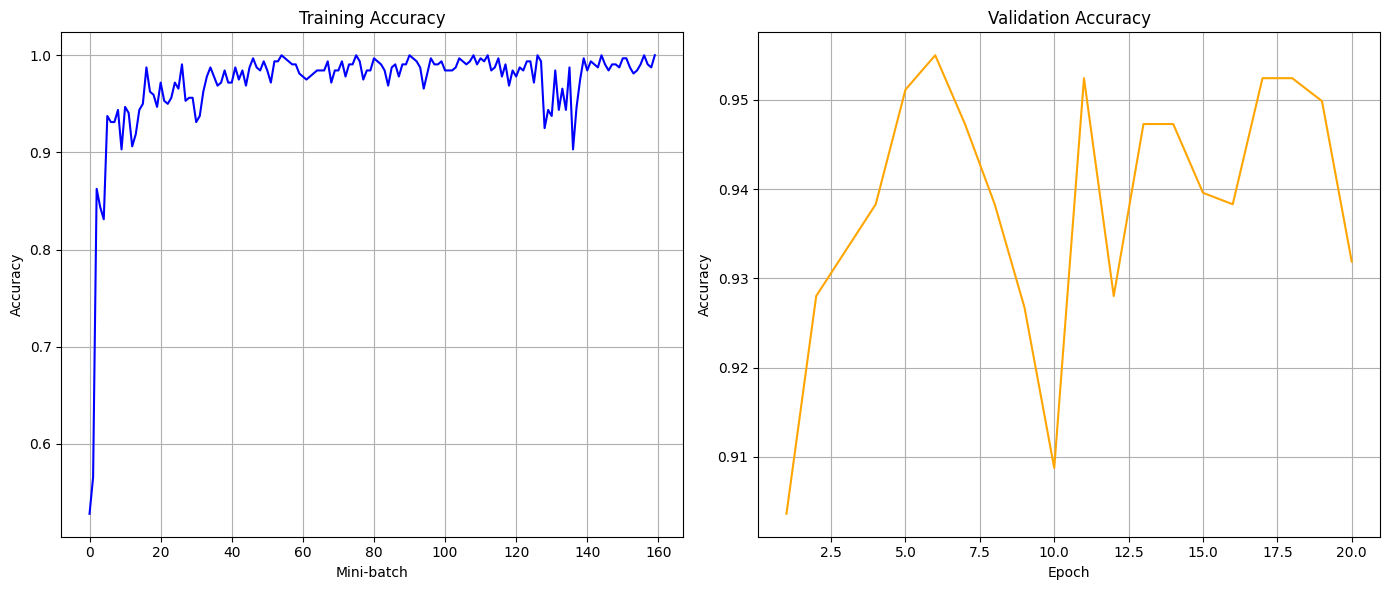

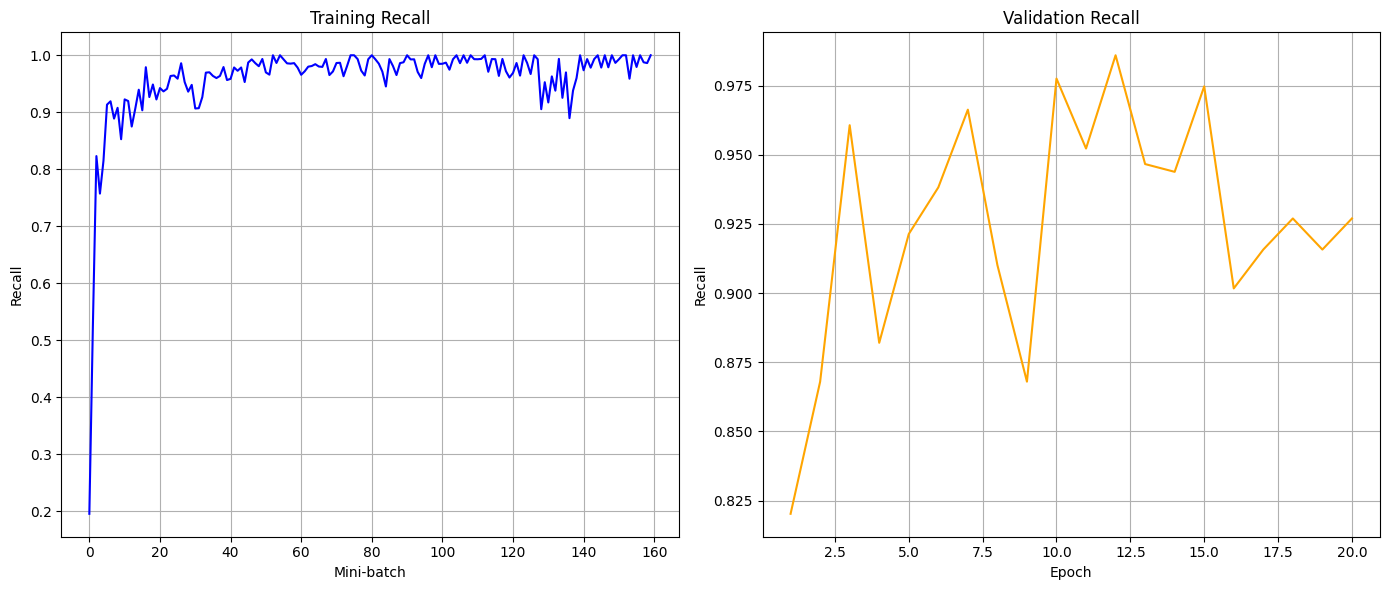

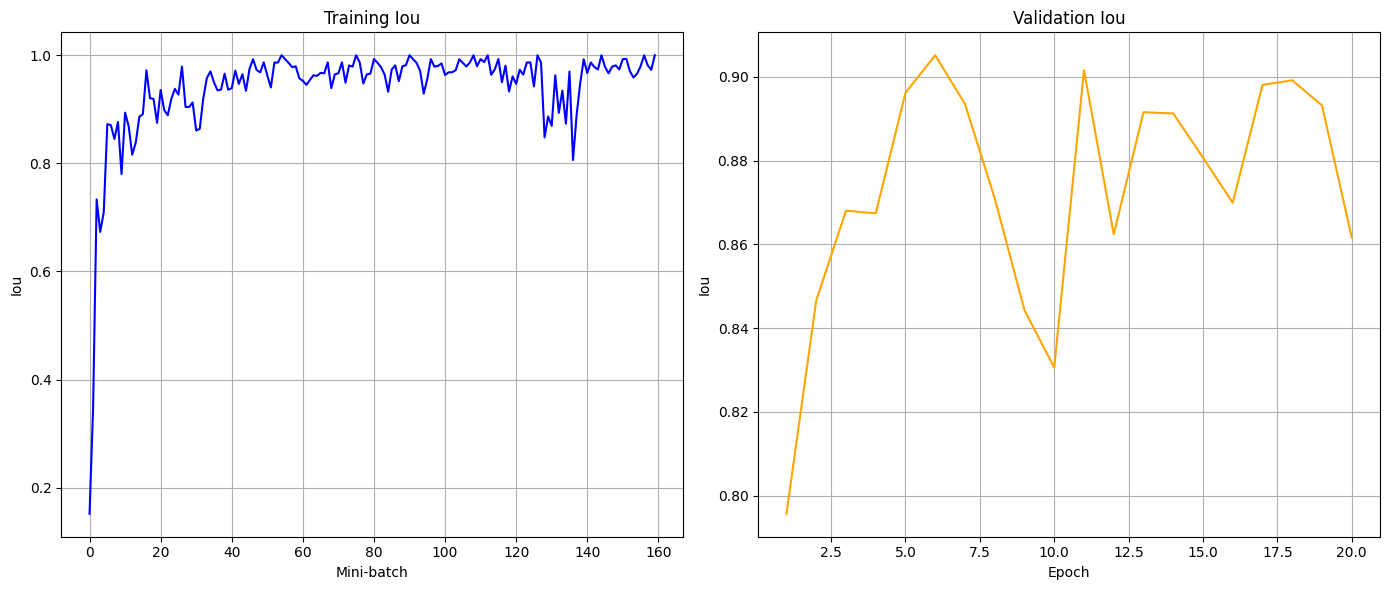

In [14]:
def plot_separate_metrics(train_metrics, val_metrics, metric_name):
    # Set up a larger plot
    plt.figure(figsize=(14, 6))

    # Subplot 1 for Training Metrics
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    train_values = [m[metric_name] for m in train_metrics]
    steps_train = list(range(len(train_values)))  # Assuming continuous recording
    plt.plot(steps_train, train_values, label='Train', color='blue')
    plt.xlabel('Mini-batch')
    plt.ylabel(metric_name.capitalize())
    plt.title(f'Training {metric_name.capitalize()}')
    plt.grid(True)

    # Subplot 2 for Validation Metrics
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    val_values = [m[metric_name] for m in val_metrics]
    epochs_val = list(range(1, len(val_values) + 1))  # Assuming recording per epoch
    plt.plot(epochs_val, val_values, label='Validation', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.capitalize())
    plt.title(f'Validation {metric_name.capitalize()}')
    plt.grid(True)

    plt.tight_layout()  # Adjust layout to not overlap
    plt.show()

# Load validation metrics
with open(f'{MODEL_DIR}/val_metrics.json', 'r') as f:
    val_metrics = json.load(f)

# Load training metrics
with open(f'{MODEL_DIR}/training_metrics.json', 'r') as f:
    train_metrics = json.load(f)

plot_separate_metrics(train_metrics, val_metrics, 'loss')
plot_separate_metrics(train_metrics, val_metrics, 'accuracy')
plot_separate_metrics(train_metrics, val_metrics, 'recall')
plot_separate_metrics(train_metrics, val_metrics, 'iou')

In [16]:
model = torch.load(f'{MODEL_DIR}/best_model_epoch_5.pth').to(device)

with torch.no_grad():
    model.eval()  # Set the model to training mode
    test_TP = 0
    test_FP = 0
    test_FN = 0
    test_TN = 0

    loop = tqdm(test_dataloader, leave=True)
    k = 0
    for i, (images, spectrograms, labels) in enumerate(loop):     
        image_0 = images[0].to(device)
        image_1 = images[1].to(device)
        image_2 = images[2].to(device)
        image_3 = images[3].to(device)
        image_4 = images[4].to(device)

        spec_0 = spectrograms[0].to(device)
        spec_1 = spectrograms[1].to(device)
        spec_2 = spectrograms[2].to(device)
        spec_3 = spectrograms[3].to(device)
        spec_4 = spectrograms[4].to(device)
        spec_5 = spectrograms[5].to(device)
        spec_6 = spectrograms[6].to(device)

        # Forward pass
        outputs = model(
            image_0, image_1, image_2, image_3, image_4,
            spec_0, spec_1, spec_2, spec_3, spec_4, spec_5, spec_6
        )

        outputs = outputs.cpu()

        # Convert labels and predictions to boolean values if they're not already
        labels_bool = labels.bool()
        _, predicted_classes = torch.max(outputs, 1)

        test_TP += ((predicted_classes == 1) & (labels_bool == 1)).sum().item()
        test_FP += ((predicted_classes == 1) & (labels_bool == 0)).sum().item()
        test_FN += ((predicted_classes == 0) & (labels_bool == 1)).sum().item()
        test_TN += ((predicted_classes == 0) & (labels_bool == 0)).sum().item()
    
    accuracy = (test_TP + test_TN) / (test_TP + test_FP + test_FN + test_TN)
    recall = test_TP / (test_TP + test_FN) if (test_TP + test_FN) > 0 else 0
    iou = test_TP / (test_TP + test_FP + test_FN) if (test_TP + test_FP + test_FN) > 0 else 0

    metric = {
        "accuracy": accuracy,
        "recall": recall,
        "iou": iou,
        "TP": test_TP,
        "FP": test_FP,
        "TN": test_TN,
        "FN": test_FN,
    }

    with open(f'{MODEL_DIR}/test_metrics.json', 'w') as f:
        json.dump(metric, f, indent=4)

    print(f"[Test Results] Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, IoU: {iou:.4f}")
print("Test finished")

100%|██████████| 13/13 [00:32<00:00,  2.49s/it]

[Test Results] Accuracy: 0.9615, Recall: 0.9462, IoU: 0.9215
Test finished
